# Serial LETKF

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import make_lorenz96, rk4, error_series_kf, plot_error_KF, estimate_error_with_params
from localization import plot_gaspari_cohn
from kalman_filters import LocalEnsembleTransformKalmanFilter as LETKF

/Users/sakajokenkyusitutakeda/.pyenv/versions/anaconda3-2020.02/envs/startup/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [13]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(0, x, 0.01, lorenz)
    return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

# KFの初期値
np.random.seed(0)
x_0 = true[np.random.randint(len(true)-1)]
P_0 = 25*I

In [5]:
import numpy as np
from numpy import sqrt, trace, zeros, identity, exp, random
from numpy.random import multivariate_normal, choice
from numpy.linalg import inv
import scipy
from scipy.linalg import sqrtm

# TODO: import改良
import sys
sys.path.append('./module')
from localization import calc_dist, polynomial, gaspari_cohn


In [11]:
#=========================
# serial LETKF
#=========================
"""
実装:
    概要:
        - ETKFを拡張．
    forecast:
        - EnKF共通．
    update:
        - input:
            - X_f: アンサンブル, (m, N) (注: Pythonでの行列の表現．実際は(N, m))
            - x_f: forecastの推定値，(N,)
            - y_obs: 観測，(N,)
        - 各時刻の観測でN=40回同化を行う．i番目の同化後のx_aをi+1番目のx_fとする．
        - 各i(in 観測の変数の数)で
            - 同化に利用する変数をi番目の変数の近くに制限．
            - input: 
                - X_f: アンサンブル, (m, N) (注: Pythonでの行列の表現．実際は(N, m))
                - x_f: (i-1)番目の推定値x_a, (N,)
                - y_obs: i番目の付近に制限，(3,)
            - output:
                - X_a: アンサンブル, (m, N)
                - x_a: i番目の推定値，(N,)
"""
class SerialLETKF:
    def __init__(self, M, H, Q, R, y, x_0, P_0, m=40, dt=0.05, alpha=1, sigma=3):
        self.M = M
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.m = m # アンサンブルメンバー数
        self.dt = dt
        
        # 実装で技術的に必要
        self.dim_x = Q.shape[0]
        self.I = identity(m)
        
        self.alpha = alpha # inflation用の定数
        self.sigma = sigma

        # filtering実行用
        self.x = [] # 記録用
        self.trP = []

        self._initialize(x_0, P_0, m)

  #　初期状態
    def _initialize(self, x_0, P_0, m):
        random.seed(0)
        self.X = x_0 + multivariate_normal(np.zeros(self.dim_x), P_0, m) # (m, J)
        self.x_mean = self.X.mean(axis=0)
    
  # 逐次推定を行う
    def forward_estimation(self):
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        X_f=self.X; x_f=self.x_mean; alpha = self.alpha; I = self.I; H = self.H; R = self.R; m = self.m; I = self.I
        
        for i in range(40):
            # dX, dYを計算
            X_f=self.X; x_f=X_f.mean(axis=0)
            dX_f = X_f - x_f # (m, dim_x)
            dX_f = sqrt(alpha)*dX_f # inflation
            dY = (H@dX_f.T).T # (m, dim_y)
        
            # Kalman gain
            K = dX_f.T@dY@inv(dY.T@dY + (m-1)*R) # (dim_x, dim_y)
            K = (self._rho(i)*K.T).T # localization
            
            # 平均を更新
            dy = self._restrict_observation(i, y_obs - H@x_f)
            x_a = x_f + K@(dy) # dim_x

            # dXを変換, I - dY^t(dYdY^t + (m-1)R)dYの平方根をとる
            S = self._symmetric(I - dY@inv(dY.T@dY + (m-1)*R)@dY.T)
            T = np.real(sqrtm(S)) # (m, m)
            self.X = x_a + (dX_f.T@T).T # (m, dim_x)
            
        self.X = X_f
        
        # 記録: 更新した値のアンサンブル平均xを保存, 推定誤差共分散P_fのtraceを保存
        self.x.append(self.X.mean(axis=0))
        self.trP.append(sqrt(trace(dX_f.T@dX_f)/40))

    # 予報/時間発展
    def _forecast(self):
        # アンサンブルで x(k) 予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)

        self.x_mean = self.X.mean(axis=0)
    
    def _restrict_observation(self, i, dy):
            rst = zeros(40)
            rst[i] = 1
            rst[(i+1)%40]=1; rst[(i-1)%40]=1
            # r[(i+2)%40]=1; r[(i-2)%40]=1
            return dy
     
    def _rho(self, i):
#         return np.array([gaspari_cohn(calc_dist(i, j), self.sigma) for j in range(self.dim_x)])

        rho = np.array([exp(-min([(i-j)**2, (i+self.dim_x-j)**2])/self.sigma) for j in range(self.dim_x)])
        return rho
    
    def _symmetric(self, S):
        return 0.5*(S + S.T)

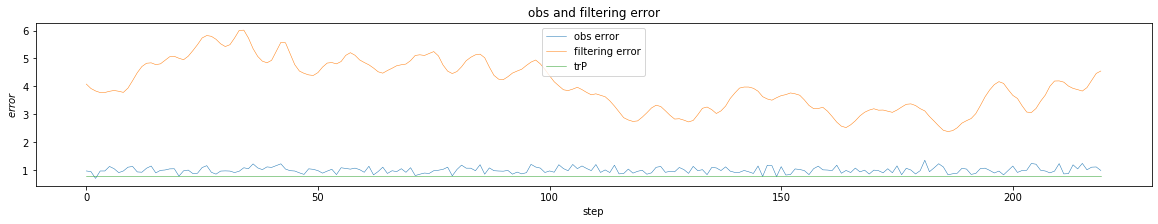

CPU times: user 46.3 s, sys: 151 ms, total: 46.4 s
Wall time: 5.82 s


(8, 0, 3.82141362191132)

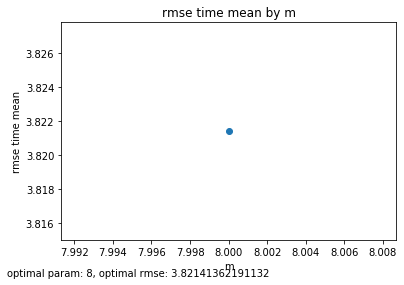

In [16]:
%%time
m = 8
alpha = 1.5
sigma = 5
letkf = SerialLETKF(M, H, Q, R, y[:220], x_0, P_0, m=m, alpha=alpha, sigma=sigma)
letkf.forward_estimation()
plot_error_KF(true, y, [letkf.x], trPs=[letkf.trP])
estimate_error_with_params(true, [letkf.x], [m], 'm')